# PREREQUISITES:

In [1]:
import os
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, TrainerCallback, GemmaTokenizerFast
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from huggingface_hub import login
import matplotlib.pyplot as plt

In [2]:
login()

Token has not been saved to git credential helper.


# Load data

In [4]:
current_directory = os.getcwd() # get current directory
file_path = os.path.join(current_directory, '..', '..', 'data', 'processed', 'clean_data.csv') # navigate to folder with preprocessed data
data = pd.read_csv(file_path)

In [5]:
print(data.head(5))

                                        heading_text  bias_rating
0  chicago gun violence spikes and increasingly f...            0
1  'bullets just came from nowhere': fourth of ju...            1
2  dozens of shootings across us mark bloody july...            2
3  federal government will run out of cash on oct...            2
4  yellen tells congress that u.s. will run out o...            0


# Data splitting and Tokenization

In [6]:
X = data['heading_text'].values
y = data['bias_rating'].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = GemmaTokenizerFast.from_pretrained('roberta-base') # load tokenizer

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    """
    We need this class to manage and load
    encoded inputs and corresponding labels into a format compatible
    with PyTorch's DataLoader for model training and evaluation :)
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)


# Train Gemma with Lora

In [11]:
# set up LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16, 
    lora_alpha=32, 
    lora_dropout=0.1 
)

In [ ]:
# load Gemma-2b
model = AutoModelForSequenceClassification.from_pretrained('google/gemma-2b', num_labels=3)
model = get_peft_model(model, lora_config)   # apply LoRA
model.print_trainable_parameters()

In [ ]:
# If available, set the device to 'cuda' (GPU), otherwise set it to 'cpu'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
# a callback class to log metrics after each epoch and save them to a CSV file
class LogMetricsCallback(TrainerCallback):
    def __init__(self, log_dir, csv_filename="gemma_lora.csv"):
        super().__init__()
        self.log_dir = log_dir
        self.csv_filepath = os.path.join(log_dir, csv_filename)
        
        # Ensure the log directory exists
        os.makedirs(log_dir, exist_ok=True)
        
        # Initialize CSV file with headers if it doesn't exist
        if not os.path.exists(self.csv_filepath):
            pd.DataFrame(columns=["epoch", "accuracy", "precision", "recall", "f1"]).to_csv(self.csv_filepath, index=False)

    def on_epoch_end(self, args, state, control, **kwargs):
        # Access the metrics from the state
        metrics = state.log_history[-1]  # Last entry should be the current epoch
        
        # Extract the current epoch number
        epoch = metrics.get("epoch")
        
        # Extract evaluation metrics
        accuracy = metrics.get("eval_accuracy")
        precision = metrics.get("eval_precision")
        recall = metrics.get("eval_recall")
        f1 = metrics.get("eval_f1")
        
        # Append metrics to CSV
        pd.DataFrame([{
            "epoch": epoch,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        }]).to_csv(self.csv_filepath, mode='a', header=False, index=False)
        
        print(f"Metrics for epoch {epoch} saved to {self.csv_filepath}")


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [17]:
torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",       
    save_strategy="epoch",        
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True, 
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# Set up log directory for metrics
log_dir = os.path.join(os.getcwd(), '..', '..', 'results')

# Initialize Trainer with early stopping and logging callbacks
trainer = Trainer(
    model=model,    
    args=training_args,  
    train_dataset=train_dataset, 
    eval_dataset=test_dataset, 
    compute_metrics=compute_metrics,
    callbacks=[
        LogMetricsCallback(log_dir=log_dir), 
        EarlyStoppingCallback(early_stopping_patience=0)     # early stopping with patience of 3 epochs
    ]
)

trainer.train()

/home1/s5153484/venvs/my_env/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.900200,0.893779,0.595999
2,0.760700,0.834693,0.629110
3,0.790000,0.883288,0.602207
4,0.535300,0.881688,0.641527
5,0.421100,0.952752,0.632559
6,0.505600,1.078053,0.626811
7,0.392000,1.212411,0.625891
8,0.347700,1.355958,0.620143
9,0.250900,1.492707,0.621062
10,0.266800,1.571382,0.613704


TrainOutput(global_step=21740, training_loss=0.5193895563455821, metrics={'train_runtime': 22959.2007, 'train_samples_per_second': 7.575, 'train_steps_per_second': 0.947, 'total_flos': 4.636961872753459e+17, 'train_loss': 0.5193895563455821, 'epoch': 10.0})

# Evaluate model

In [22]:
metrics = trainer.evaluate()
print(f"Test Accuracy: {metrics['eval_accuracy']}")

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.881688,0.641527


Test Accuracy: 0.6415267877673029


# Train and Test loss graph

   Epoch  Training Loss  Validation Loss  Accuracy
0      1         0.9002         0.893779  0.595999
1      2         0.7607         0.834693  0.629110
2      3         0.7413         0.813288  0.641207


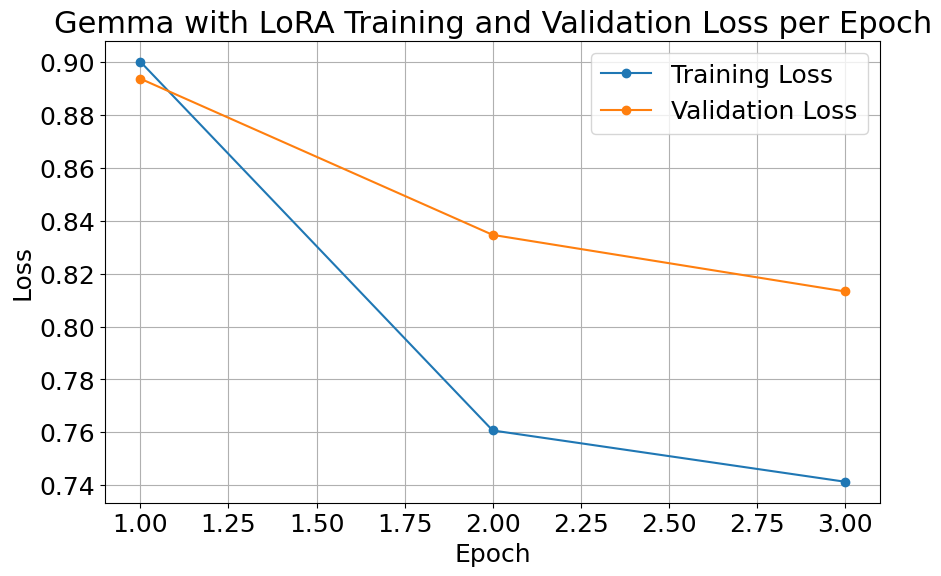

In [10]:
file_path = os.path.join(current_directory, '..', '..', 'results', 'gemma_lora.csv') # navigate to folder with results
data_to_plot = pd.read_csv(file_path)
print(data_to_plot.head(3))

plt.figure(figsize=(10, 6))
plt.plot(data_to_plot['Epoch'], data_to_plot['Training Loss'], label='Training Loss', marker='o')
plt.plot(data_to_plot['Epoch'], data_to_plot['Validation Loss'], label='Validation Loss', marker='o')
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.title("Gemma with LoRA Training and Validation Loss per Epoch", fontsize=22)

# Set legend font size
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(True)
plt.show()